In [1]:
using Plots
using TensorCrossInterpolation, LinearAlgebra
using QuanticsTCI
using QuanticsGrids
using ITensorMPS
using ITensors
using NDTensors
using TCIITensorConversion
using IterativeSolvers
using LinearMaps
using LinearAlgebra
include("src/2D_QIS.jl")
plotlyjs()

Plots.PlotlyJSBackend()

In [ ]:
# simulation parameter
R = 10
max_bond = 39
dx = 1 / (2^R-1)
delta_t = 0.1 * 2.0^-(R-1)

nu = 1e-5
penalty_coefficient = 2.5e5

# define grid
grid = DiscretizedGrid{2}(R, (0,0), (1,1); includeendpoint = true)

# define sites
s = siteinds("Qudit", R, dim=4)
println("del_t = $(delta_t)")

del_t = 0.0001953125


In [3]:
# initial conditions

x_min = 0.4
x_max = 0.6
h = 1/200

function d_1_func(x, y)
    out = 2 / h^2 * ( (y - x_max) * exp( -(y - x_max)^2 / h^2 ) + (y - x_min) * exp( -(y - x_min)^2 / h^2 ) )
    return out * ( sin(8π * x) + sin(24π * x) + sin(6π * x) ) 
end

function d_2_func(x, y)
    out = π * ( exp( -(y - x_max)^2 / h^2 ) + exp( -(y - x_min)^2 / h^2 ) )
    return out * ( 8*cos(8π * x) + 24*cos(24π * x) + 6*cos(6π * x) ) 
end

function A_func(x, y)
    return sqrt( d_1_func(x,y)^2 + d_2_func(x,y)^2 )
end

A = find_max_on_2D_grid(A_func, R)
u_0 = 1.
delta_var = u_0 / (40 * A)

function J_1_func(y)
    return u_0 / 2 * ( tanh( (y - x_min)/h ) - tanh( (y - x_max)/h ) - 1 )
end

function D_1_func(x, y)
    return delta_var * d_1_func(x, y)
end

function D_2_func(x, y)
    return delta_var * d_2_func(x, y)
end

function u_init_1_func(x, y)
    return J_1_func(y) + D_1_func(x, y)
end

function u_init_2_func(x, y)
    return D_2_func(x, y)
end

u_init_2_func (generic function with 1 method)

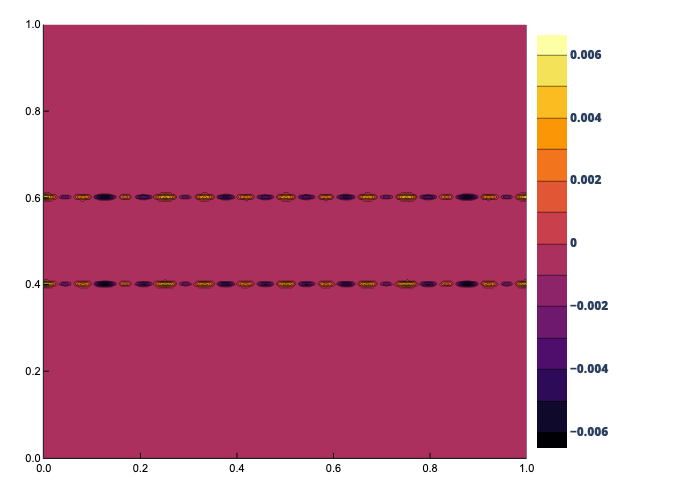

In [4]:
 # build mps with QuanticsTCI
u1q, ranks1, errors1 = quanticscrossinterpolate(Float64, u_init_1_func, grid; maxbonddim=max_bond)
u2q, ranks2, errors2 = quanticscrossinterpolate(Float64, u_init_2_func, grid; maxbonddim=max_bond)

# convert to ITensorMPS format
ux = deepcopy(ITensorMPS.MPS(TensorTrain(u1q.tci), sites=s))
uy = deepcopy(ITensorMPS.MPS(TensorTrain(u2q.tci), sites=s))

# build base MPO's
d1x = Diff_1_8_x(dx, s)
d1y = Diff_1_8_y(dx, s)
d2x = Diff_2_8_x(dx, s)
d2y = Diff_2_8_y(dx, s)
dx_dx = apply(d1x, d1x, maxdim=max_bond)
dy_dy = apply(d1y, d1y, maxdim=max_bond)
dx_dy = apply(d1x, d1y, maxdim=max_bond)
del = MPO([delta(s[i], s[i]', s[i]'') for i in 1:length(s)])
plot_mps(uy; trunc=1e-3)

In [5]:
t0 = time()
ux_t, uy_t = RK4_step(ux, uy, delta_t, nu, d1x, d1y, d2x, d2y, del, dx_dx, dy_dy, dx_dy, max_bond)
println("Time: $(time()-t0)")
plot_mps(uy_t; grid_size=8, trunc=1e-5, save_name="figures/V_t_1.pdf")

Time: 124.74663591384888


"/Users/niklasbliemel/Work/krones/mps/figures/V_t_1.pdf"

In [ ]:
t0 = time()
for i in 2:11
    ux_t, uy_t = RK4_step(ux_t, uy_t, delta_t, nu, d1x, d1y, d2x, d2y, del, dx_dx, dy_dy, dx_dy, max_bond)
    plot_mps(uy_t; grid_size=8, trunc=1e-5, save_name="figures/V_t_$i.pdf")
end
println("Time: $(time()-t0)")

Time: 2544.211595058441


In [12]:
min, sek = divrem(2544, 60)
println("$min min\t$sek sek")#
println("$(2544/10) sek / evolution")


42 min	24 sek
254.4 sek / evolution


In [15]:
n = 500
println("$(trunc(Int, n * 254.4/3600))h for $n simulations")

35h for 500 simulations
